# Reproducing Philander's 2014 study using [*gamba*](https://github.com/gamba-dev/gamba)

This notebook shows how gamba can be used to reproduce findings from Philander's 2014 study on data mining methods for detecting high-risk gamblers.

- [Data Download (thetransparencyproject.org)](http://www.thetransparencyproject.org/download_index.php)
- [Data Description]()
- [Original Paper](https://www.tandfonline.com/doi/abs/10.1080/14459795.2013.841721)

It uses data available through the transaparency project above, and performs nine distinct supervised machine learning techniques.
To begin, import gamba as usual;

In [1]:
import gamba as gb

thank you for using gamba!


In [2]:
raw_data = gb.read_csv('RawDataSet2_DailyAggregation.txt', delimiter='\t', parse_dates=['TimeDATE'])
analytic_data = gb.read_csv('AnalyticDataSet_HighRisk.txt', delimiter='\t')
print(len(analytic_data))

530


In [113]:
import numpy as np

philander_data = analytic_data.copy()
philander_data['self_exclude'] = np.where(philander_data['Sereason'] == 3, 1, 0) # apply the binary self-exclude technique (middle of page 5)
philander_data.drop(labels=['UserID','Sereason','random','p2clusteringactivity','p2clusterhalf1','p2clusterhalf2'], axis=1, inplace=True)
philander_data.columns = ['country','gender','age','total_wagered','num_bets','frequency','duration','bets_per_day','net_loss',
                          'intensity','variability','frequency','trajectory',
                          'z_intensity','z_variability','z_frequency','z_trajectory','self_exclude']
#display(philander_data)
 
train_table = philander_data.sample(frac=.696) # randomly takes a fraction (69.6% to be precise, equal to 369 rows) of the data as the training set
test_table = philander_data.drop(train_table.index)

train_data = train_table.drop(['self_exclude'], axis=1).values
train_labels = train_table['self_exclude'].values
test_data = test_table.drop(['self_exclude'], axis=1)
test_labels = test_table['self_exclude'].values

print('train:validation split of\n', len(train_labels),':',len(test_labels), 'ready')

train:validation split of
 369 : 161 ready


okay this is gonna be a lot, here are the 9 methods;
- [stepwise logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
- [lasso logistic regression](https://scikit-learn.org/dev/modules/linear_model.html#lars-lasso)
- [neural network (regression]()
- [neural network (classification]()
- [SVM (e-regression)]()
- [SVM (c-classification)]()
- [SVM (1-classification)]()
- [random forest (regression)]()
- [random forest (classification)]()

## Logistic Regression

## Neural Networks
The following cell uses the [Keras](https://keras.io) library to create and train some neural networks as described in the study.

In [92]:
from keras.layers import Dense, Activation
from keras.models import Sequential

model = Sequential()
model.add(Dense(10, activation = 'relu', input_dim = 17))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error',
              metrics=['accuracy'])

history = model.fit(train_data, train_labels, 
                    batch_size = 10, epochs = 10,
                    validation_data=(test_data, test_labels))

raw_prediction = model.predict(test_data)
prediction = [value[0] for value in np.where(raw_prediction > 0.5, 1, 0)]

results = model.evaluate(test_data, test_labels)

Using TensorFlow backend.


Train on 369 samples, validate on 161 samples
Epoch 1/10
369/369 [==============================] - 0s 872us/step - loss: 23659.0378 - accuracy: 0.0081 - val_loss: 10442.1524 - val_accuracy: 0.0124
Epoch 2/10
369/369 [==============================] - 0s 97us/step - loss: 11762.2042 - accuracy: 0.0244 - val_loss: 2925.7215 - val_accuracy: 0.0186
Epoch 3/10
369/369 [==============================] - 0s 109us/step - loss: 2565.1199 - accuracy: 0.0325 - val_loss: 1826.4607 - val_accuracy: 0.0497
Epoch 4/10
369/369 [==============================] - 0s 119us/step - loss: 1846.5679 - accuracy: 0.0352 - val_loss: 2394.1852 - val_accuracy: 0.0248
Epoch 5/10
369/369 [==============================] - 0s 107us/step - loss: 4123.7911 - accuracy: 0.0488 - val_loss: 7263.1929 - val_accuracy: 0.0621
Epoch 6/10
369/369 [==============================] - 0s 121us/step - loss: 2535.5793 - accuracy: 0.0759 - val_loss: 1523.1280 - val_accuracy: 0.0745
Epoch 7/10
369/369 [==============================] 

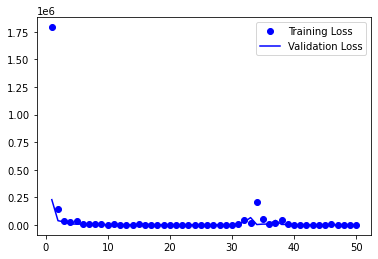

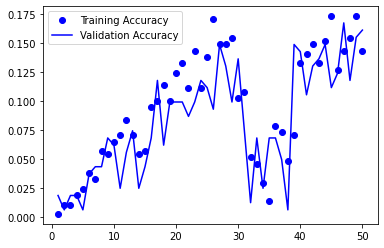

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

import matplotlib.pyplot as plt
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.legend()

## Support Vector Machines (SVMs)
The following cell uses [scikit-learn's SVM](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm) methods to create and trains some SVM's. The original paper uses Dimitriadou et al's [implementations in R described here](https://www.researchgate.net/profile/Friedrich_Leisch/publication/221678005_E1071_Misc_Functions_of_the_Department_of_Statistics_E1071_TU_Wien/links/547305880cf24bc8ea19ad1d/E1071-Misc-Functions-of-the-Department-of-Statistics-E1071-TU-Wien.pdf).

In [115]:
from sklearn import svm, metrics
import pandas as pd

### SVM eps-Regression

In [96]:
def svm_eps_regression(train_data, train_labels, test_data):
    model = svm.SVR(kernel='rbf')

    model.fit(train_data, train_labels)

    predicted_labels = model.predict(test_data)

    # convert probabilities to binary labels for comparison
    regression_cutoff = 0.5
    predicted_labels = np.where(predicted_labels < regression_cutoff, 0, 1)
    
    return predicted_labels

### SVM C-Support Vector Classification

In [97]:
def svm_c_classification(train_data, train_labels, test_data):
    
    model = svm.SVC(kernel='rbf')

    model.fit(train_data, train_labels)

    predicted_labels = model.predict(test_data)
    
    return predicted_labels

### SVM one-Classification

In [98]:
def svm_one_classification(train_data, train_labels, test_data):
    model = svm.OneClassSVM(kernel='rbf')

    model.fit(train_data, train_labels)

    predicted_labels = model.predict(test_data)

    # need to add a correction step for the labels here as OneClassSVM returns -1 for outliers and 1 for inliers
    predicted_labels = np.where(predicted_labels < 0, 1, 0)
    
    return predicted_labels

## Random Forest
This section implements [scikit-learn's ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html#forest) to create random forests for classification and regression

### RF Regression

In [103]:
from sklearn.ensemble import RandomForestRegressor

def rf_regression(train_data, train_labels, test_data):
    model = RandomForestRegressor()

    model.fit(train_data, train_labels)

    predicted_labels = model.predict(test_data)

    # convert probabilities to binary labels for comparison
    regression_cutoff = 0.5
    predicted_labels = np.where(predicted_labels < regression_cutoff, 0, 1)

    return predicted_labels

### RF Classification

In [104]:
from sklearn.ensemble import RandomForestClassifier

def rf_classification(train_data, train_labels, test_data):
    model = RandomForestClassifier(n_estimators=100)

    model.fit(train_data, train_labels)

    predicted_labels = model.predict(test_data)

    return predicted_labels

## All Methods Together

In [120]:
def performance(method, actual, predicted):
    # resources:
    # describes odds ratio and precision equations
    # https://cran.r-project.org/web/packages/ROCR/ROCR.pdf
    # describes sklearn's confusion matrix
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn-metrics-confusion-matrix

    result = metrics.classification_report(actual, y_pred=predicted, output_dict=True)
    sensitivity = result['1']['recall']
    specificity = result['0']['recall']
    accuracy = result['accuracy']
    fpr, tpr, thresholds = metrics.roc_curve(actual, predicted)
    auc = metrics.auc(fpr, tpr)
    # odds ratio is (tp x tn)/(fp x fn)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion_matrix.ravel()
    odds_ratio = 0
    if fp != 0 and fn != 0:
        odds_ratio = (tp * tn)/(fp * fn)
    # precision is tp / (tp + fp)
    precision = tp / (tp + fp)
    #if odds_ratio == 0:
    #    print('tn,fp,fn,tp\n', tn,fp,fn,tp)

    metrics_df = pd.DataFrame()
    metrics_df['sensitivity'] = [round(sensitivity, 3)]
    metrics_df['specificity'] = [round(specificity, 3)]
    metrics_df['accuracy'] = [round(accuracy, 3)]
    metrics_df['precision'] = [round(precision, 3)]
    metrics_df['auc'] = [round(auc, 3)]
    metrics_df['odds_ratio'] = [round(odds_ratio, 3)]
    metrics_df.index = [method]
    return metrics_df

svm_e = svm_eps_regression(train_data, train_labels, test_data)
svm_c = svm_c_classification(train_data, train_labels, test_data)
svm_o = svm_one_classification(train_data, train_labels, test_data)
rf_r = rf_regression(train_data, train_labels, test_data)
rf_c = rf_classification(train_data, train_labels, test_data)

all_results = [
    performance('SVM eps-Regression', test_labels, svm_e),
    performance('SVM c-Classification', test_labels, svm_c),
    performance('SVM one-Classification', test_labels, svm_o),
    performance('RF Regression', test_labels, rf_r),
    performance('RF Classification', test_labels, rf_c)
]

all_results_df = pd.concat(all_results)
display(all_results_df)

,sensitivity,specificity,accuracy,precision,auc,odds_ratio
SVM eps-Regression,0.020,1.000,0.689,1.000,0.510,0.000
SVM c-Classification,0.000,1.000,0.683,NaN,0.500,0.000
SVM one-Classification,0.431,0.536,0.503,0.301,0.484,0.878
RF Regression,0.275,0.882,0.689,0.519,0.578,2.823
RF Classification,0.118,0.945,0.683,0.500,0.532,2.311
